In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
NYC_PREPARED_DATA_PATH = 'data/NYPD_Shooting_Incident_Data_PREPARE.csv'

## Read data

In [3]:
nyc_df = pd.read_csv(NYC_PREPARED_DATA_PATH)

In [12]:
nyc_df

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,loc_classf,location_d,statistica,...,vic_sex,vic_race,latitude,longitude,geometry,year,month,day,weekday,cluster
0,228798151,2021-05-27,00:00:00.000,21:30:00,QUEENS,NaN,105.0,NaN,NaN,F,...,M,BLACK,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025),2021,5,27,3,-1
1,137471050,2014-06-27,00:00:00.000,17:40:00,BRONX,NaN,40.0,NaN,NaN,F,...,M,BLACK,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006),2014,6,27,4,0
2,147998800,2015-11-21,00:00:00.000,03:56:00,QUEENS,NaN,108.0,NaN,NaN,T,...,M,WHITE,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004),2015,11,21,5,-1
3,146837977,2015-10-09,00:00:00.000,18:30:00,BRONX,NaN,44.0,NaN,NaN,F,...,M,WHITE HISPANIC,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003),2015,10,9,4,0
4,58921844,2009-02-19,00:00:00.000,22:58:00,BRONX,NaN,47.0,NaN,NaN,T,...,M,BLACK,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006),2009,2,19,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27293,245029823,2022-05-14,00:00:00.000,03:02:00,BRONX,OUTSIDE,48.0,STREET,(null),F,...,M,BLACK,40.846864,-73.901413,POINT (-73.90141321 40.84686352),2022,5,14,5,0
27294,239583450,2022-01-22,00:00:00.000,13:15:00,MANHATTAN,OUTSIDE,30.0,STREET,(null),F,...,M,WHITE HISPANIC,40.826743,-73.952273,POINT (-73.952273 40.826743),2022,1,22,5,4
27295,246825728,2022-06-18,00:00:00.000,03:29:00,MANHATTAN,OUTSIDE,32.0,STREET,(null),F,...,M,BLACK,40.810209,-73.939496,POINT (-73.9394955 40.81020941),2022,6,18,5,4
27296,246876579,2022-06-19,00:00:00.000,20:08:00,BRONX,INSIDE,46.0,HOUSING,MULTI DWELL - PUBLIC HOUS,F,...,M,WHITE HISPANIC,40.855644,-73.896141,POINT (-73.896141 40.855644),2022,6,19,6,0


In [13]:
missing_values = nyc_df[['latitude', 'longitude','vic_age_gr']].isnull().sum()
missing_values

latitude      0
longitude     0
vic_age_gr    0
dtype: int64

In [14]:
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude','vic_age_gr'])

# DBSCAN from API analyze only coords (works only with latitude and longitude)

In [6]:
clean_coords = nyc_df[['latitude', 'longitude']].to_numpy()

In [7]:
clean_coords

array([[ 40.66296462, -73.73083869],
       [ 40.81035186, -73.92494233],
       [ 40.74260663, -73.91549174],
       ...,
       [ 40.81020941, -73.9394955 ],
       [ 40.855644  , -73.896141  ],
       [ 40.837102  , -73.847134  ]])

In [8]:
# Define the range of parameters for the experiment
eps_values = np.arange(0.001, 0.027, 0.005)  # Possible epsilon values
min_samples_values = range(5, 20, 5)  # Possible minimum sample values

In [9]:
eps_values

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

In [35]:
# Variables to store the best parameters and the best silhouette score
best_eps = None
best_min_samples = None
best_silhouette = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(clean_coords)
        if len(set(db.labels_)) > 1:  # Silhouette_score cannot be calculated with a single cluster
            sil_score = silhouette_score(clean_coords, db.labels_)
            # Check if this is the best silhouette score so far
            if sil_score > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = sil_score

(best_eps, best_min_samples, best_silhouette)

(0.026000000000000002, 5, 0.3466068330042389)

In [10]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean = DBSCAN(eps=0.0025, min_samples=15).fit(clean_coords)
# db_clean = DBSCAN(eps=0.026000000000000002, min_samples=5).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
 2    8392
 0    5321
-1    3612
 4    2821
 1     681
Name: count, dtype: int64

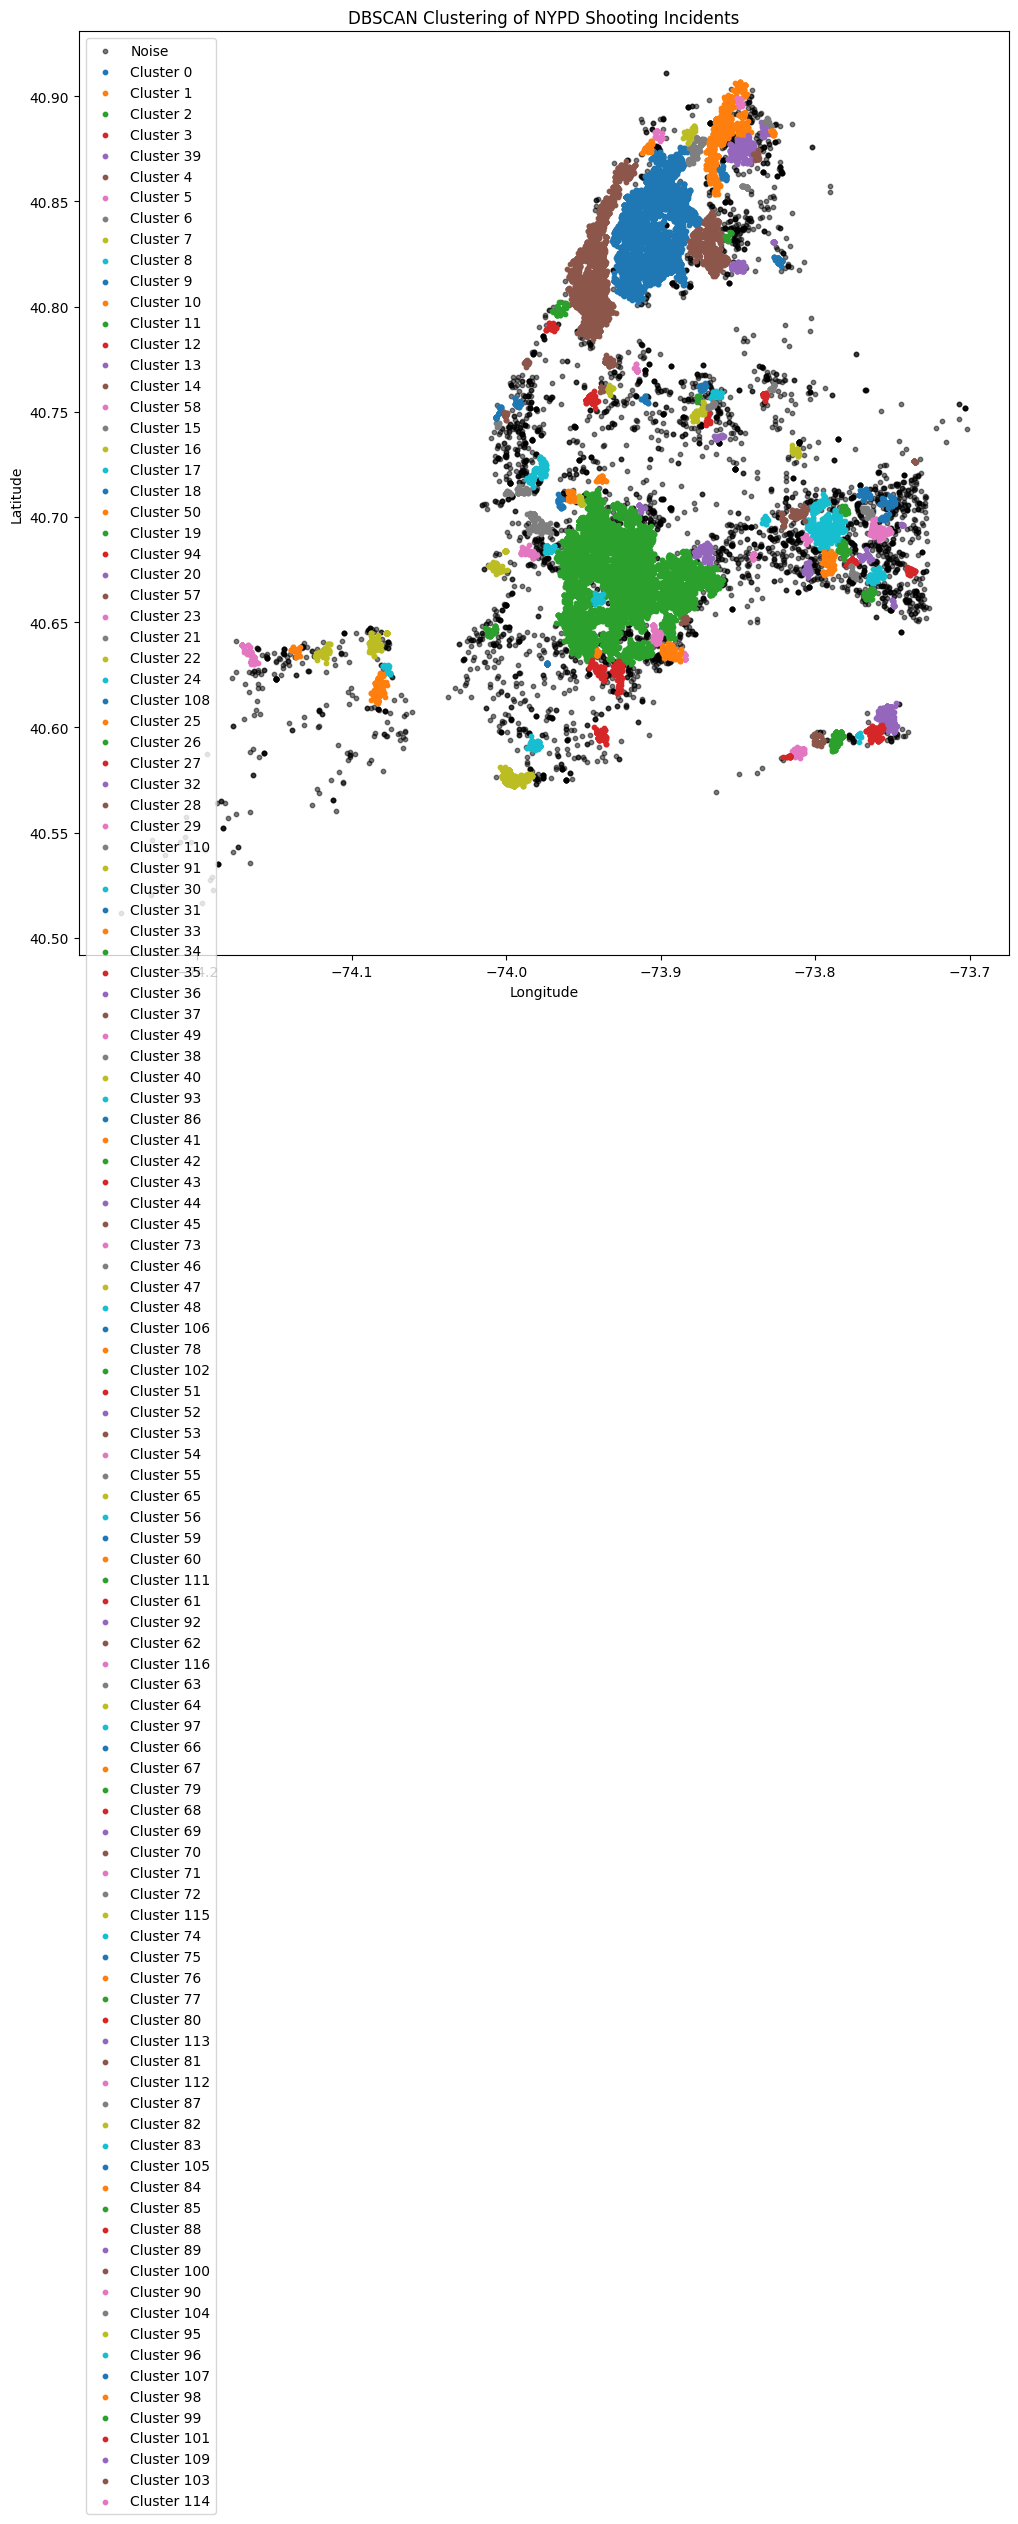

In [11]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plotting each cluster with a different color
labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

# Setting up additional parameters for the plot
ax.set_title('DBSCAN Clustering of NYPD Shooting Incidents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()

# DBSCAN from API analyze coords with one more column

In [33]:
clean_coords_with_vic_age_col = nyc_df[['latitude', 'longitude','vic_age_gr']].to_numpy()

In [34]:
np.unique(clean_coords_with_vic_age_col[:,2])

array(['18-24', '25-44', '45-64', '65+', '<18', 'UNKNOWN'], dtype=object)

Change string values to float (mapping)

In [36]:
age_group_mapping = {'<18': 0, '18-24': 1, '25-44': 2, '45-64': 3, '65+': 4,'UNKNOWN': 5}
mapping_function = np.vectorize(lambda x: age_group_mapping.get(x, x))
clean_coords_with_vic_age_col_mapped = mapping_function(clean_coords_with_vic_age_col)

In [38]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean_3cols = DBSCAN(eps=0.0025, min_samples=15).fit(clean_coords_with_vic_age_col_mapped)
# db_clean = DBSCAN(eps=0.026000000000000002, min_samples=5).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean_3cols.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
-1     11429
 2      2267
 7      1966
 0      1562
 10     1002
Name: count, dtype: int64

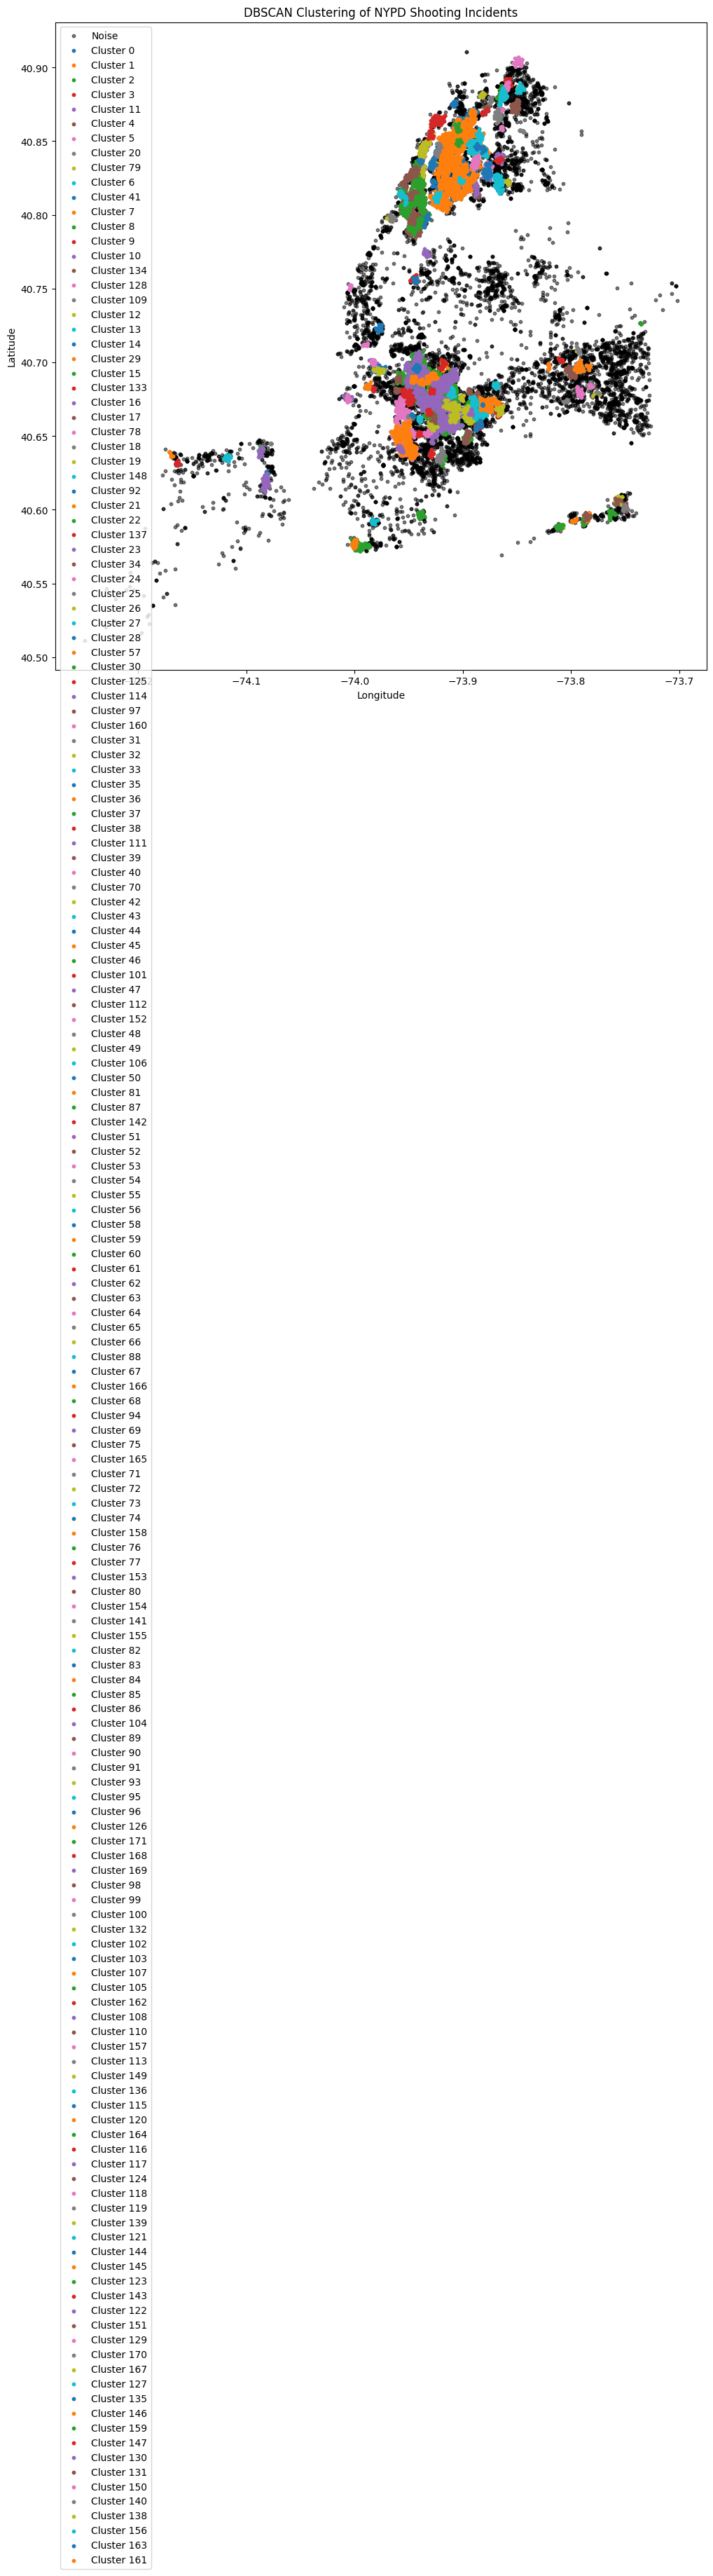

In [39]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plotting each cluster with a different color
labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

# Setting up additional parameters for the plot
ax.set_title('DBSCAN Clustering of NYPD Shooting Incidents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()